In [31]:
import pickle
import numpy as np
import nltk
from __future__ import print_function
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras import backend
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import Adadelta
from keras.constraints import unitnorm
from keras.regularizers import l2
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

# Data preprocessing<a id='datapreprocessing'></a>

In [2]:
data = pickle.load(open("yelp_review_dataset"))
print(data[0]["review"])

Fried chicken and waffles floored me!!!  Juicy and flavorful. Well done. Place has a good vibe, wait staff and I would return if it was in New York.


In [3]:
reviews = []
i=0
while(i<len(data)):
    reviews.append(data[i]["review"].lower())
    i+=1

labels = []
i=0
while(i<len(data)):
    if(data[i]["ratingValue"]>3):
        labels.append(1)
    else:
        labels.append(0)
    i+=1

print(len(reviews))
print(len(labels))

15000
15000


In [4]:
labels_train = labels[:12000]
labels_test = labels[-3000:]
reviews_train = reviews[:12000]
reviews_test = reviews[-3000:]

In [5]:
positive_counts = Counter()
negative_counts = Counter()
total_counts = Counter()

In [6]:
for i in range(len(reviews)):
    if labels[i] == 1:
        words_positive = word_tokenize(reviews[i])
        for word in words_positive:
            positive_counts[word] +=1
            total_counts[word] +=1
    else:
        word_negative = word_tokenize(reviews[i])
        for word in word_negative:
            negative_counts[word] +=1
            total_counts[word] +=1

In [7]:
positive_counts.most_common()

[(u'the', 86959),
 (u'.', 86527),
 (u',', 63456),
 (u'and', 59688),
 (u'a', 43359),
 (u'i', 41600),
 (u'was', 33836),
 (u'to', 31277),
 (u'of', 25498),
 (u'it', 24724),
 (u'!', 19512),
 (u'is', 19456),
 (u'for', 18992),
 (u'with', 16918),
 (u'in', 16712),
 (u'we', 15400),
 (u'but', 13600),
 (u'you', 12543),
 (u'that', 12180),
 (u'my', 12179),
 (u'this', 11697),
 (u'were', 11101),
 (u'on', 10867),
 (u'had', 9876),
 (u"n't", 9260),
 (u'so', 9206),
 (u'they', 9178),
 (u')', 8935),
 (u'food', 8875),
 (u"'s", 8757),
 (u'(', 8421),
 (u'good', 8121),
 (u'have', 7560),
 (u'as', 7245),
 (u'not', 7212),
 (u'place', 7023),
 (u'are', 7017),
 (u'great', 6759),
 (u'at', 6453),
 (u'very', 6003),
 (u'our', 5692),
 (u'here', 5654),
 (u'all', 5583),
 (u'be', 5486),
 (u'which', 5254),
 (u'there', 4876),
 (u'like', 4732),
 (u'if', 4672),
 (u'-', 4626),
 (u'also', 4612),
 (u'one', 4452),
 (u'really', 4338),
 (u'service', 4330),
 (u'out', 4314),
 (u'their', 4292),
 (u'delicious', 4281),
 (u'would', 4224),
 

In [8]:
negative_counts.most_common()

[(u'.', 34429),
 (u'the', 34272),
 (u',', 23376),
 (u'and', 19376),
 (u'i', 17677),
 (u'was', 15669),
 (u'a', 15579),
 (u'to', 13479),
 (u'it', 10349),
 (u'of', 9397),
 (u'for', 7793),
 (u'but', 6565),
 (u'we', 6338),
 (u'that', 5859),
 (u'in', 5840),
 (u'is', 5547),
 (u'with', 5378),
 (u"n't", 5260),
 (u'were', 5204),
 (u'my', 5114),
 (u'not', 4698),
 (u'this', 4211),
 (u'on', 4082),
 (u'food', 3922),
 (u'had', 3818),
 (u'they', 3652),
 (u'you', 3450),
 (u'so', 3203),
 (u'good', 3151),
 (u"'s", 3128),
 (u'at', 3124),
 (u')', 2946),
 (u'(', 2852),
 (u'have', 2726),
 (u'!', 2695),
 (u'our', 2603),
 (u'be', 2562),
 (u'place', 2412),
 (u'just', 2343),
 (u'as', 2333),
 (u'like', 2189),
 (u'did', 2177),
 (u'there', 2164),
 (u'would', 2110),
 (u'if', 2059),
 (u'out', 1997),
 (u'are', 1918),
 (u'me', 1891),
 (u'very', 1874),
 (u'service', 1851),
 (u'all', 1810),
 (u'here', 1792),
 (u'which', 1790),
 (u'do', 1780),
 (u'ordered', 1738),
 (u'...', 1627),
 (u'or', 1618),
 (u'really', 1595),
 (u'c

In [9]:
pos_neg_ratios = Counter()

for word,count in list(total_counts.most_common()):
    if(count >= 100):
        pos_neg_ratio = positive_counts[word] / float(negative_counts[word]+1)
        pos_neg_ratios[word] = pos_neg_ratio

In [10]:
pos_neg_ratios.most_common()

[(u'delight', 33.333333333333336),
 (u'gem', 26.625),
 (u'busboys', 21.8),
 (u'die', 20.444444444444443),
 (u'divine', 20.4),
 (u'wonderful', 17.9),
 (u'falafel', 17.181818181818183),
 (u'omg', 15.555555555555555),
 (u'whenever', 13.0),
 (u'fantastic', 12.042857142857143),
 (u'pudding', 12.0),
 (u'satisfying', 11.846153846153847),
 (u'ambar', 11.818181818181818),
 (u'favorites', 11.6),
 (u'yellow', 11.5),
 (u'perfect', 11.108108108108109),
 (u'regret', 10.916666666666666),
 (u'reasonably', 10.8),
 (u'relaxed', 10.666666666666666),
 (u'disappoint', 10.5),
 (u'affordable', 10.5),
 (u'perfectly', 10.450980392156863),
 (u'heart', 10.444444444444445),
 (u'nights', 10.285714285714286),
 (u'notch', 10.23076923076923),
 (u'impeccable', 10.2),
 (u'incredible', 10.179487179487179),
 (u'outstanding', 10.11111111111111),
 (u'cozy', 9.96774193548387),
 (u'hole', 9.727272727272727),
 (u'superb', 9.722222222222221),
 (u'recommendations', 9.533333333333333),
 (u'phenomenal', 9.521739130434783),
 (u'pe

In [11]:
list(reversed(pos_neg_ratios.most_common()))[0:30]

[(u'worst', 0.18072289156626506),
 (u'poor', 0.21428571428571427),
 (u'mediocre', 0.21578947368421053),
 (u'terrible', 0.2346368715083799),
 (u'horrible', 0.25471698113207547),
 (u'rude', 0.27439024390243905),
 (u'charged', 0.28421052631578947),
 (u'disappointing', 0.3031674208144796),
 (u'dirty', 0.3247863247863248),
 (u'attitude', 0.32558139534883723),
 (u'burnt', 0.4),
 (u'bland', 0.41333333333333333),
 (u'meh', 0.4369747899159664),
 (u'lacked', 0.45045045045045046),
 (u'understand', 0.4819277108433735),
 (u'ok.', 0.49732620320855614),
 (u'sadly', 0.5),
 (u'mess', 0.5232558139534884),
 (u'elsewhere', 0.5238095238095238),
 (u'overcooked', 0.5408163265306123),
 (u'okay', 0.5704697986577181),
 (u'disappointment', 0.5733333333333334),
 (u'eventually', 0.5909090909090909),
 (u'soggy', 0.6138613861386139),
 (u'paid', 0.6481481481481481),
 (u'alright', 0.6511627906976745),
 (u'overpriced', 0.6521739130434783),
 (u'lost', 0.6557377049180327),
 (u'lacking', 0.6777777777777778),
 (u'ok', 0.68

In [12]:
for word,ratio in pos_neg_ratios.most_common():
    if(ratio>1):
        pos_neg_ratios[word] = np.log(ratio)
    else:
        pos_neg_ratios[word] = - np.log((1/(ratio + 0.01)))

In [13]:
pos_neg_ratios.most_common()

[(u'delight', 3.5065578973199818),
 (u'gem', 3.2818506240295893),
 (u'busboys', 3.0819099697950434),
 (u'die', 3.0177111802727663),
 (u'divine', 3.0155349008501706),
 (u'wonderful', 2.884800712846709),
 (u'falafel', 2.8438517422612719),
 (u'omg', 2.7444178452730847),
 (u'whenever', 2.5649493574615367),
 (u'fantastic', 2.4884717159524965),
 (u'pudding', 2.4849066497880004),
 (u'satisfying', 2.4720032449520923),
 (u'ambar', 2.469639177657212),
 (u'favorites', 2.451005098112319),
 (u'yellow', 2.4423470353692043),
 (u'perfect', 2.4076753018520103),
 (u'regret', 2.3902906734131513),
 (u'reasonably', 2.379546134130174),
 (u'relaxed', 2.367123614131617),
 (u'disappoint', 2.3513752571634776),
 (u'affordable', 2.3513752571634776),
 (u'perfectly', 2.346695791441519),
 (u'heart', 2.3460702049337847),
 (u'nights', 2.3307559699607419),
 (u'notch', 2.325399770760217),
 (u'impeccable', 2.3223877202902252),
 (u'incredible', 2.320374634557544),
 (u'outstanding', 2.3136349291806306),
 (u'cozy', 2.299354

In [14]:
list(reversed(pos_neg_ratios.most_common()))[0:30]

[(u'worst', -1.6569337339036772),
 (u'poor', -1.4948345296950967),
 (u'mediocre', -1.4881522462265149),
 (u'terrible', -1.4079803250274479),
 (u'horrible', -1.3290940194377523),
 (u'rude', -1.2574078857819615),
 (u'charged', -1.2234596919994327),
 (u'disappointing', -1.161017340663981),
 (u'dirty', -1.0942627871200161),
 (u'attitude', -1.0918907429077829),
 (u'burnt', -0.89159811928378352),
 (u'bland', -0.85959538819760972),
 (u'meh', -0.80525308435730314),
 (u'lacked', -0.77555002853214594),
 (u'understand', -0.70942350246511354),
 (u'ok.', -0.67860108344980108),
 (u'sadly', -0.67334455326376552),
 (u'mess', -0.62875401882374926),
 (u'elsewhere', -0.6277162006393544),
 (u'overcooked', -0.59635387108071325),
 (u'okay', -0.54391750562703878),
 (u'disappointment', -0.5389965007326869),
 (u'eventually', -0.5093116189347755),
 (u'soggy', -0.47182707288729525),
 (u'paid', -0.41832522383776916),
 (u'alright', -0.41375519003065397),
 (u'overpriced', -0.41222704902207924),
 (u'lost', -0.406859

In [15]:
vocab = set()
for item in total_counts:
    vocab.add(item)

vocab_size = len(vocab)
print(vocab_size)

32599


In [16]:
word2index = {}
for i,word in enumerate(vocab):
    word2index[word] = i

print(word2index)

{u'*clutches': 0, u'fawn': 1, u'mid-week': 2, u'redzepi': 3, u'woods': 4, u'clotted': 5, u'hanging': 6, u'woody': 7, u'goodtony': 27098, u'comically': 9, u'cake-': 10, u'originality': 11, u'everything.i': 12, u'kotopoulo': 13, u"'finger": 14, u'calpico': 15, u'convivial:1': 16, u'fattiness': 17, u'butter-esque': 18, u'bringing': 19, u'wooden': 20, u'wednesday': 21, u'broiled': 23, u'tour.http': 24, u'elgar': 25, u'paradisio': 26, u'everything.-': 27, u'dish.i': 28, u'chimichuri': 29, u'270': 30, u'dish.~': 31, u'nitro.we': 32, u'scraped': 33, u'inanimate': 34, u'errors': 35, u'cooking': 36, u'amazzing': 37, u'designing': 38, u'mini-dessert': 39, u'succumb': 40, u'shocks': 41, u'dish.-': 42, u'ching': 43, u'china': 44, u'post-move': 45, u'wagyu': 46, u'affiliated': 47, u'wiseguy': 48, u'natured': 49, u'kids': 50, u'uplifting': 51, u'naturel': 52, u'climbed': 53, u'controversy': 54, u'meats/tofu': 55, u'dish.overall': 56, u'spotty': 57, u'wings/legs': 58, u'golden': 59, u'projection': 60

In [17]:
reviews_w2n = np.empty(15000, dtype=list)
for i in range(len(reviews)):
    a = []
    for word in word_tokenize(reviews[i]):
        a.append(word2index[word])
    reviews_w2n[i] = a

print(len(reviews_w2n))
print(reviews_w2n[0])

15000
[15595, 32341, 24654, 17827, 30350, 20623, 21253, 21253, 21253, 11274, 24654, 2147, 322, 19978, 21351, 322, 22915, 393, 27513, 14981, 11655, 28573, 28990, 21938, 24654, 11956, 5969, 31700, 12407, 12397, 18563, 12403, 12137, 32265, 322]


In [18]:
labels_train = labels[:12000]
labels_test = labels[-3000:]
reviews_train = reviews_w2n[:12000]
reviews_test = reviews_w2n[-3000:]

In [19]:
avg_len = list(map(len, reviews_w2n))
print(np.mean(avg_len))

166.4384


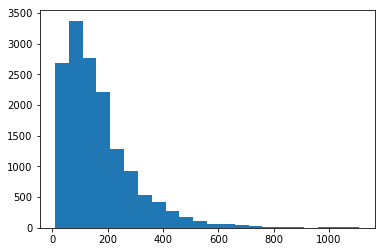

In [20]:
plt.hist(avg_len, bins = range(min(avg_len), max(avg_len) + 50, 50))
plt.show()

# Model<a id='model'></a>

In [71]:
maxword = 400
reviews_train = sequence.pad_sequences(reviews_train, maxlen = maxword)
reviews_test = sequence.pad_sequences(reviews_test, maxlen = maxword)

In [72]:
#model references, keras official example: https://github.com/keras-team/keras/blob/master/examples/imdb_cnn.py
max_features = len(total_counts)
maxlen = 400
batch_size = 32
embedding_dims = 64
filters = 64
kernel_size = 3
hidden_dims = 250
epochs = 2

In [73]:
model = Sequential()
model.add(Embedding(max_features, embedding_dims,input_length=maxlen))
model.add(Dropout(0.2))
model.add(Conv1D(filters,kernel_size,padding='valid',activation='relu',strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [74]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 400, 64)           2086336   
_________________________________________________________________
dropout_21 (Dropout)         (None, 400, 64)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 398, 64)           12352     
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 250)               16250     
_________________________________________________________________
dropout_22 (Dropout)         (None, 250)               0         
_________________________________________________________________
activation_19 (Activation)   (None, 250)               0         
__________

# Results<a id='results'></a>

In [75]:
model.fit(reviews_train, labels_train,batch_size=batch_size,epochs=epochs,validation_data=(reviews_test, labels_test))

Train on 12000 samples, validate on 3000 samples
Epoch 1/2
12000/12000 [==============================] - 42s 4ms/step - loss: 0.4418 - acc: 0.7970 - val_loss: 0.3508 - val_acc: 0.8463
Epoch 2/2
12000/12000 [==============================] - 39s 3ms/step - loss: 0.1801 - acc: 0.9312 - val_loss: 0.3509 - val_acc: 0.8590
